In [104]:
import numpy as np
import pandas as pd
import logging
import warnings
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error
from prophet.diagnostics import cross_validation, performance_metrics

# Suppress cmdstanpy logs (used by Prophet internally)
logging.getLogger("cmdstanpy").setLevel(logging.CRITICAL)

# Suppress Prophet "seasonality" and future warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# By Orders

In [105]:
df_o = pd.read_csv('Dataset/daily_coffee_count.csv')

In [106]:
df_o['date'] = pd.to_datetime(df_o['date'])

In [107]:
df_o.head()

,date,order_count
0,2024-03-01,11
1,2024-03-02,7
2,2024-03-03,10
3,2024-03-04,4
4,2024-03-05,9


In [108]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [109]:
df_general_o = df_o.copy()

In [110]:
df_general_o = df_general_o.rename(columns={'date': 'ds', 'order_count': 'y'})
df_general_o = df_general_o[['ds', 'y']]

In [111]:
# Step 1: Log transform
df_general_o['y'] = np.log1p(df_general_o['y'])

Daily Prophet MAE: 6.23
Daily Prophet RMSE: 7.17
Daily Prophet MAPE: 31.49%


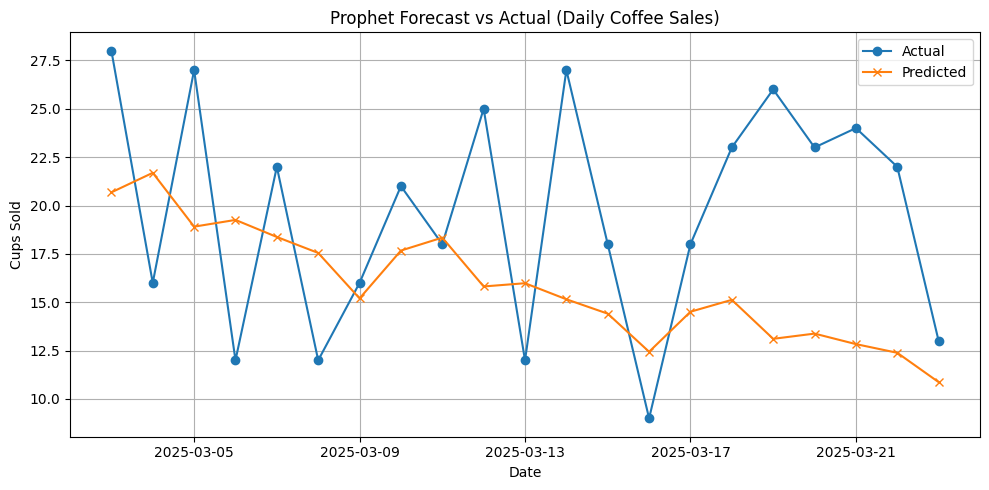

In [ ]:
# Step 2: Split into train/test (last 21 days)
train_df = df_general_o[:-21]
test_df = df_general_o[-21:]

# Step 3: Train the model
model = Prophet(
    daily_seasonality=True,         # Now relevant for daily data
    weekly_seasonality=True,
    yearly_seasonality=True
)
model.add_country_holidays(country_name='MY')
model.fit(train_df)

# Step 4: Create future DataFrame for next 21 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"Daily Prophet MAPE: {mape:.2f}%")

# Step 8: Plot
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

### Tuning

In [113]:
df_general_o = df_o.copy()

In [114]:
df_general_o = df_general_o.rename(columns={'date': 'ds', 'order_count': 'y'})
df_general_o = df_general_o[['ds', 'y']]

In [116]:
# Step 0: Log-transform y to stabilize variance
df_general_o['y'] = np.log1p(df_general_o['y'])

Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale     0.050000
seasonality_prior_scale    15.000000
mae                         0.282599
rmse                        0.316213
mape                        0.101783
Name: 7, dtype: float64

Final Test MAE (best model): 6.15
Final Test RMSE (best model): 7.07
Final Test MAPE (best model): 31.30%


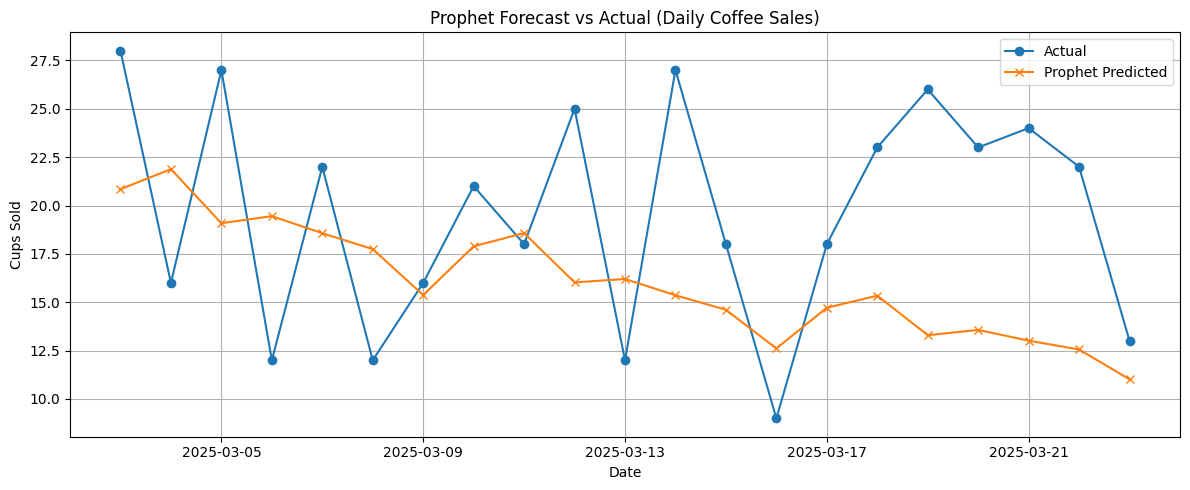

In [117]:
# Step 1: Split train/test (last 21 days)
train_df = df_general_o[:-21].copy()
test_df = df_general_o[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df[results_df['mape'].notnull()].sort_values(by='mape').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"Final Test RMSE (best model): {rmse:.2f}")
print(f"Final Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Cups Sold")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

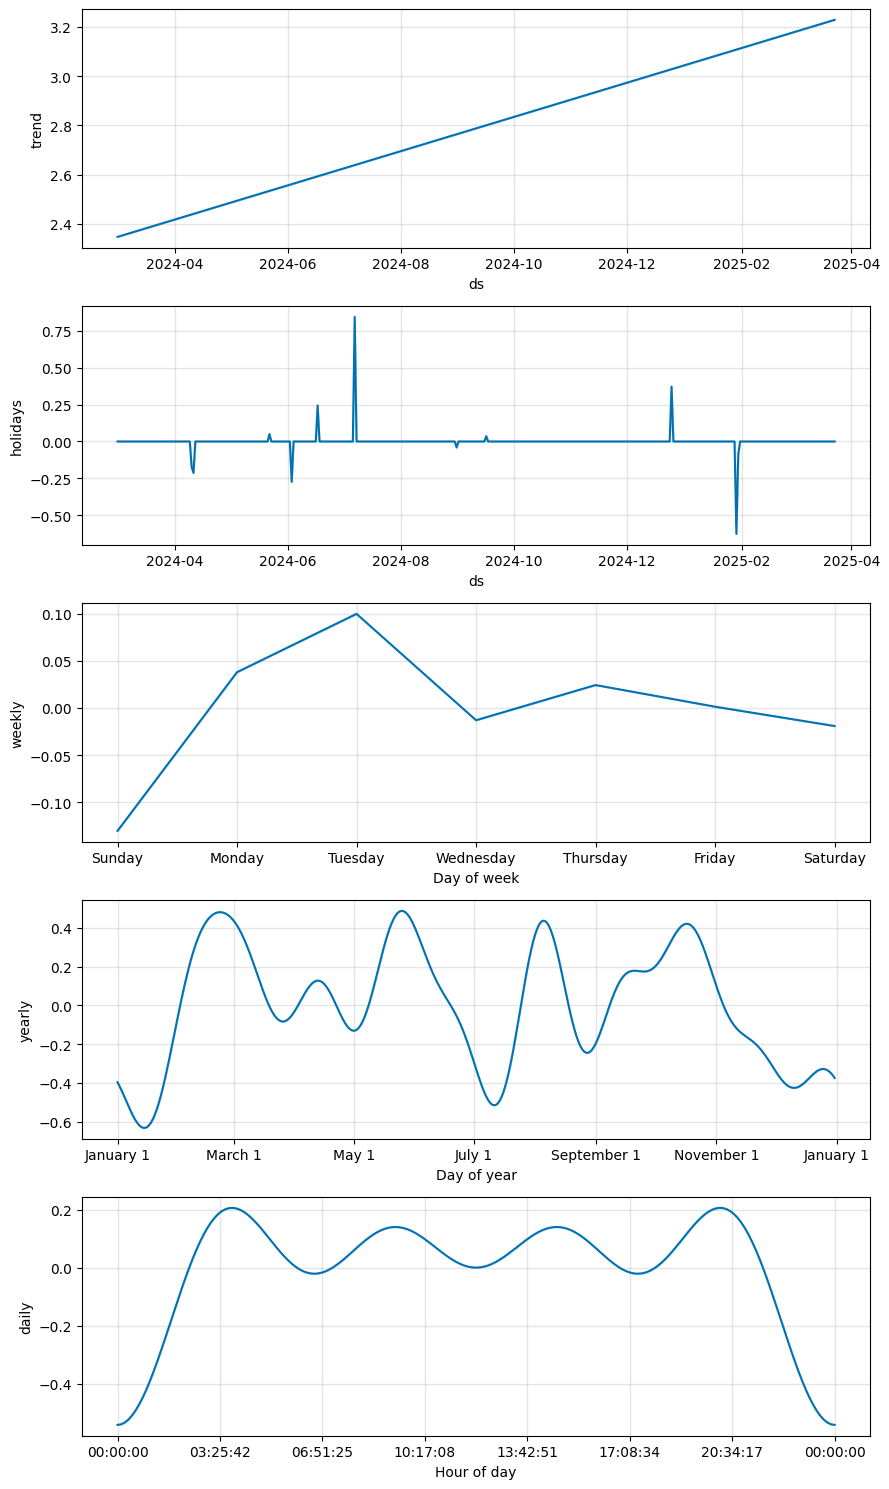

In [118]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()

# By Sales

In [119]:
df_s = pd.read_csv('Dataset/daily_coffee_sales.csv')

In [120]:
df_s['date'] = pd.to_datetime(df_s['date'])

In [121]:
df_s.head()

,date,total_sales
0,2024-03-01,396.3
1,2024-03-02,228.1
2,2024-03-03,349.1
3,2024-03-04,135.2
4,2024-03-05,338.5


In [122]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

## General

In [123]:
df_general_s = df_s.copy()

In [124]:
df_general_s = df_general_s.rename(columns={'date': 'ds', 'total_sales': 'y'})
df_general_s = df_general_s[['ds', 'y']]

In [125]:
df_general_s['y'] = np.log1p(df_general_s['y'])

Daily Prophet MAE: 219.73
Daily Prophet RMSE: 252.75
Daily Prophet MAPE: 35.05%


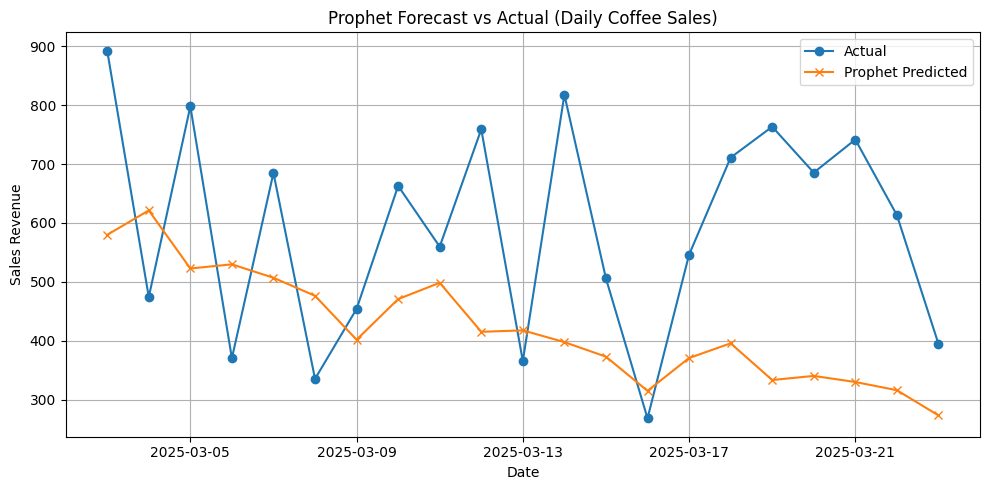

In [126]:
# Step 1: Split into train and test sets
train_df = df_general_s[:-21]
test_df = df_general_s[-21:]

# Step 2: Train the model on the training set
model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True 
)
model.add_country_holidays(country_name='MY') 
model.fit(train_df)

# Step 4: Create future DataFrame for next 21 days
future = model.make_future_dataframe(periods=21, freq='D')

# Step 5: Predict
forecast = model.predict(future)

# Step 6: Inverse transform and clip
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)

# Step 7: Evaluation on test set only
forecast_test = forecast[-21:].copy()
y_true = np.expm1(test_df['y'].values)
y_pred = forecast_test['yhat'].values

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"Daily Prophet MAE: {mae:.2f}")
print(f"Daily Prophet RMSE: {rmse:.2f}")
print(f"Daily Prophet MAPE: {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(10, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()  

### Tuning

In [127]:
df_general_s = df_s.copy()

In [128]:
df_general_s = df_general_s.rename(columns={'date': 'ds', 'total_sales': 'y'})
df_general_s = df_general_s[['ds', 'y']]

In [129]:
# Step 0: Log-transform y to stabilize variance
df_general_s['y'] = np.log1p(df_general_s['y'])

Training: changepoint_prior_scale=0.01, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.01, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.05, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.1, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=1.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=5.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=10.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.


Training: changepoint_prior_scale=0.3, seasonality_prior_scale=15.0


Seasonality has period of 365.25 days which is larger than initial window. Consider increasing initial.



Best Parameters:
changepoint_prior_scale    0.050000
seasonality_prior_scale    1.000000
mae                        0.296709
rmse                       0.326467
mape                       0.048390
Name: 4, dtype: float64

Final Test MAE (best model): 234.73
Final Test RMSE (best model): 272.64
Final Test MAPE (best model): 36.52%


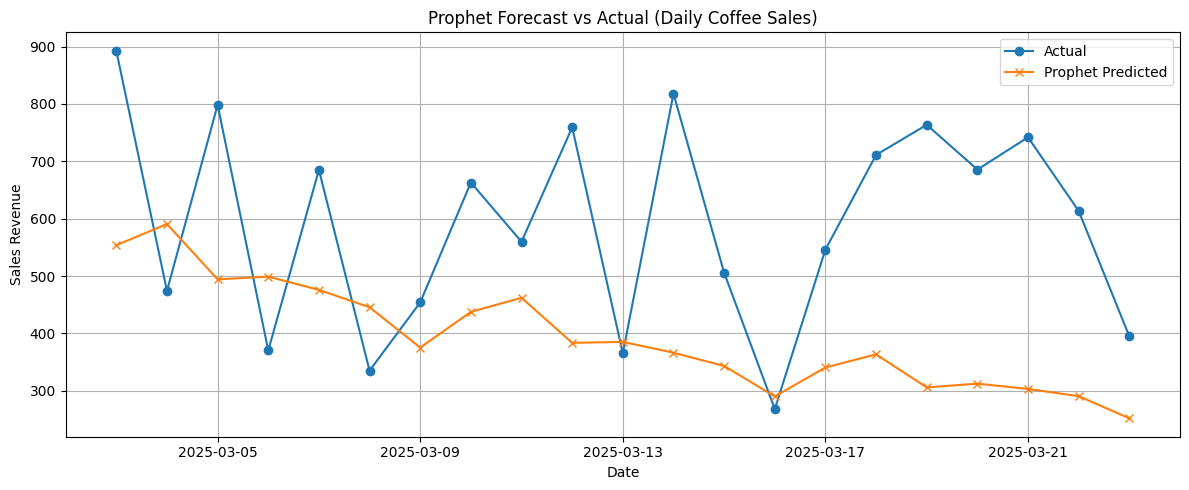

In [130]:
# Step 1: Split train/test (last 21 days)
train_df = df_general_s[:-21].copy()
test_df = df_general_s[-21:].copy()

# Step 2: Define parameter grid
changepoint_range = [0.01, 0.05, 0.1, 0.3]
seasonality_range = [1.0, 5.0, 10.0, 15.0]

results = []

# Step 3: Grid search over parameters
for cp in changepoint_range:
    for sp in seasonality_range:
        print(f"Training: changepoint_prior_scale={cp}, seasonality_prior_scale={sp}")
        m = Prophet(
            daily_seasonality=True,
            weekly_seasonality=True,
            yearly_seasonality=True,
            changepoint_prior_scale=cp,
            seasonality_prior_scale=sp
        )
        m.add_country_holidays(country_name='MY')

        m.fit(train_df)

        # Run cross-validation
        df_cv = cross_validation(m, initial='345 days', period='7 days', horizon='21 days', parallel="processes")
        df_p = performance_metrics(df_cv)

        avg_mape = df_p['mape'].mean()
        avg_mae = df_p['mae'].mean()
        avg_rmse = df_p['rmse'].mean()

        results.append({
            'changepoint_prior_scale': cp,
            'seasonality_prior_scale': sp,
            'mae': avg_mae,
            'rmse': avg_rmse,
            'mape': avg_mape
        })

# Step 4: Display best params
results_df = pd.DataFrame(results)
best_params = results_df[results_df['mape'].notnull()].sort_values(by='mape').iloc[0]
print("\nBest Parameters:")
print(best_params)

# Step 5: Retrain with best parameters on full training data
best_model = Prophet(
    daily_seasonality=True,
    weekly_seasonality=True,
    yearly_seasonality=True,
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale']
)
best_model.add_country_holidays(country_name='MY')
best_model.fit(train_df)

# Step 6: Forecast next 21 days
future = best_model.make_future_dataframe(periods=21, freq='D')
forecast = best_model.predict(future)

# Step 7: Inverse transform and evaluate
forecast['yhat'] = np.expm1(forecast['yhat']).clip(lower=0)
y_true = np.expm1(test_df['y'].values)
y_pred = forecast['yhat'].values[-21:]

mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mape = mean_absolute_percentage_error(y_true, y_pred)
print(f"\nFinal Test MAE (best model): {mae:.2f}")
print(f"Final Test RMSE (best model): {rmse:.2f}")
print(f"Final Test MAPE (best model): {mape:.2f}%")

# Step 8: Plot forecast vs actual
plt.figure(figsize=(12, 5))
plt.plot(test_df['ds'], y_true, label='Actual', marker='o')
plt.plot(test_df['ds'], y_pred, label='Prophet Predicted', marker='x')
plt.title("Prophet Forecast vs Actual (Daily Coffee Sales)")
plt.xlabel("Date")
plt.ylabel("Sales Revenue")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

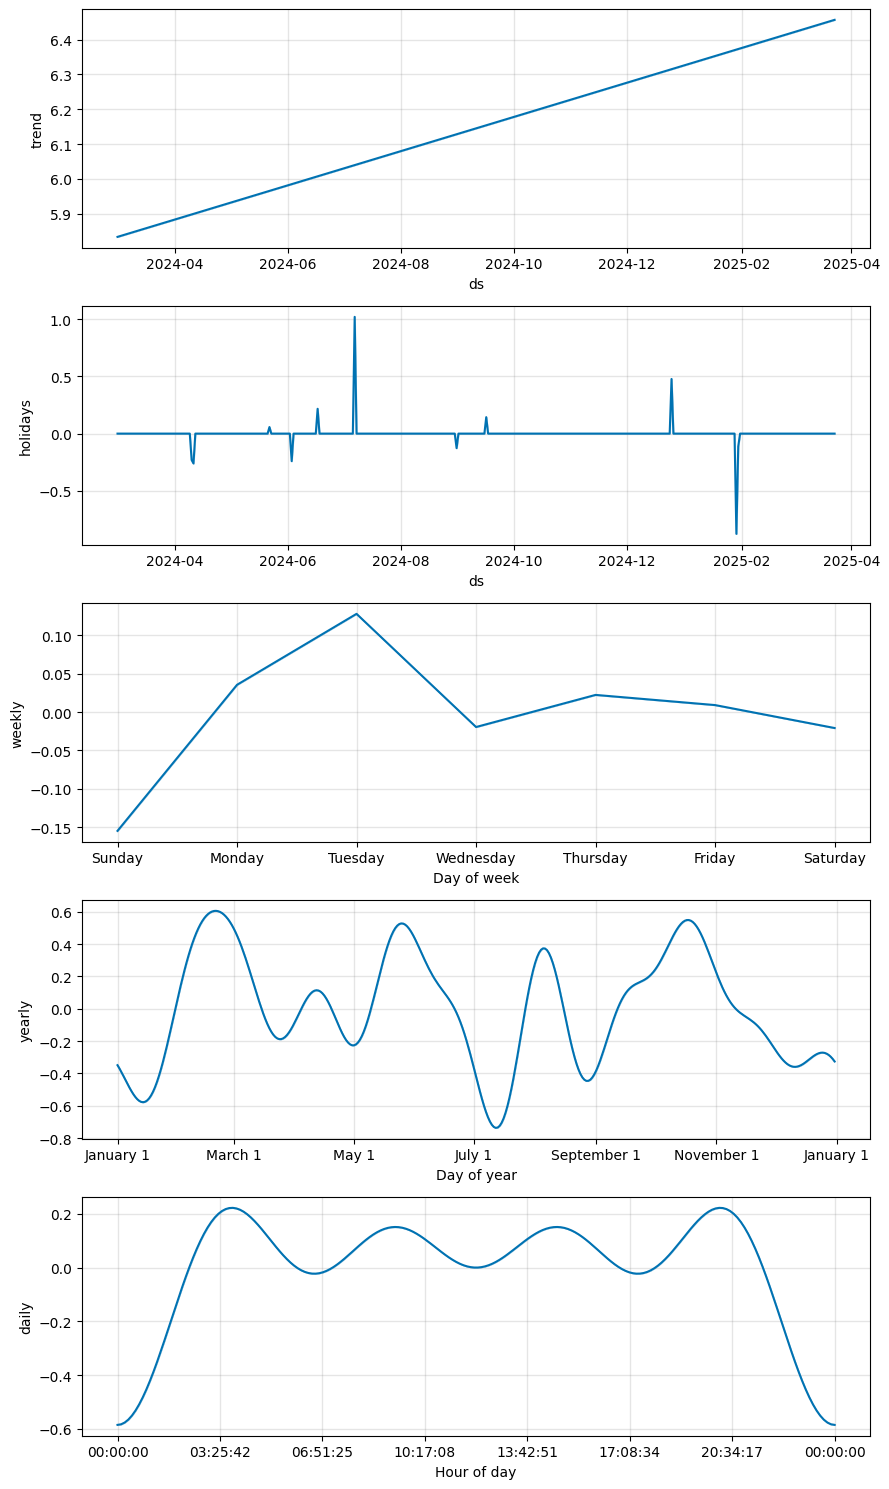

In [131]:
fig = best_model.plot_components(forecast)
plt.tight_layout()
plt.show()